In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [7]:
embedding_dim = 8
max_number = 20
base = 10

#Random embeddings
random_embedding = nn.Embedding(max_number + 1, embedding_dim)
torch.manual_seed(42)
with torch.no_grad():
    random_embedding.weight.copy_(torch.randn_like(random_embedding.weight))



#Abacus digit-wise embedding
digit_embedding = nn.Embedding(base, embedding_dim)

def abacus_embed(n):
    digits = [int(d) for d in str(n)]
    embeddings = digit_embedding(torch.tensor(digits))
    return embeddings.sum(dim=0)

In [9]:
def evaluate_commutativity(embedding_func):
    loss = 0
    for a in range(0, 11):
        for b in range(0, 11):
            emb_sum = embedding_func(a) + embedding_func(b)
            emb_total = embedding_func(a + b)
            loss += torch.norm(emb_sum - emb_total).item()
    return loss

print("Random Embedding Loss:", evaluate_commutativity(lambda x: random_embedding(torch.tensor(x))))
print("Abacus Embedding Loss:", evaluate_commutativity(abacus_embed))

Random Embedding Loss: 550.3789885044098
Abacus Embedding Loss: 481.911493062973


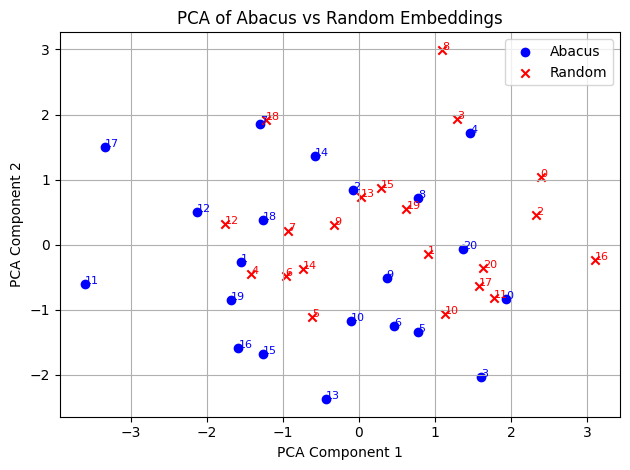

In [15]:
def PCA_plot():
    abacus = np.array([abacus_embed(i).detach().numpy() for i in range(max_number + 1)])
    randoms = np.array([random_embedding(torch.tensor(i)).detach().numpy() for i in range(max_number + 1)])

    combined = np.vstack((abacus, randoms))
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(combined)
    abacus_2d = reduced[:max_number+1]
    randoms_2d = reduced[max_number+1:]

    plt.scatter(abacus_2d[:, 0], abacus_2d[:, 1], color='blue', label='Abacus')
    plt.scatter(randoms_2d[:, 0], randoms_2d[:, 1], color='red', label='Random', marker='x')

    for i in range(max_number + 1):
        plt.annotate(str(i), xy=(abacus_2d[i, 0], abacus_2d[i, 1]), color='blue', fontsize=8)
        plt.annotate(str(i), xy=(randoms_2d[i, 0], randoms_2d[i, 1]), color='red', fontsize=8)

    plt.title("PCA of Abacus vs Random Embeddings")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

PCA_plot()